In [ ]:
#!pip uninstall qiskit qiskit-nature -y
!pip install "qiskit==0.44.0" "qiskit-nature==0.6.2"
!pip install qiskit-nature-pyscf
!pip install numpy==1.25.2

  Using cached qiskit_nature-0.6.2-py3-none-any.whl.metadata (7.4 kB)
Using cached qiskit_nature-0.6.2-py3-none-any.whl (4.1 MB)
  Attempting uninstall: qiskit-nature
    Found existing installation: qiskit-nature 0.7.2
    Uninstalling qiskit-nature-0.7.2:
      Successfully uninstalled qiskit-nature-0.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qiskit-nature-pyscf 0.4.0 requires qiskit-nature>=0.7.1, but you have qiskit-nature 0.6.2 which is incompatible.


ERROR: Operation cancelled by user
^C
^C


In [ ]:
from pyscf import gto, dft
import numpy as np
import os

distancias = np.linspace(0.20, 3.00, 200)


for d in distancias:
    d_str = f"{d:.2f}".replace('.', '_')

    mol = gto.M(
        atom=f'H 0 0 0; H 0 0 {d}',
        basis='sto-3g',
        unit='Angstrom',
        verbose = 0,
    )

    mf = dft.RKS(mol)
    mf.xc = 'b3lyp'
    mf.kernel()

    n = mol.nao_nr()

    hcore = mf.get_hcore()
    eri_ao = mol.intor('int2e')
    eri_ao_flat = eri_ao.reshape(n**2, n**2)  # 2x2 = 4
    C = mf.mo_coeff

    np.savetxt(f"integral_1e_{d_str}.txt", hcore, fmt="%.10f")
    np.savetxt(f"integral_2e_{d_str}.txt", eri_ao_flat, fmt="%.10f")
    np.savetxt(f"coef_KS_{d_str}.txt", C, fmt="%.10f")

/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
import numpy as np


distancias = np.linspace(0.20, 3.00, 200)

for d in distancias:
    d_str = f"{d:.2f}".replace('.', '_')

    h_ao = np.loadtxt(f"integral_1e_{d_str}.txt")
    eri_ao_flat = np.loadtxt(f"integral_2e_{d_str}.txt")
    C = np.loadtxt(f"coef_KS_{d_str}.txt")

    eri_ao = eri_ao_flat.reshape(2,2,2,2)

    h_mo = C.T @ h_ao @ C
    np.savetxt(f"h_mo_{d_str}.txt", h_mo, fmt="%.10f")

    g_mo = np.zeros((2, 2, 2, 2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    for p in range(2):
                        for q in range(2):
                            for r in range(2):
                                for s in range(2):
                                    g_mo[i, j, k, l] += (
                                    C[p, i] * C[r, k] *
                                    eri_ao[p, r, q, s] *
                                    C[q, j] * C[s, l]
                                    )

    np.savetxt(f"g_mo_{d_str}.txt", g_mo.reshape(4,4), fmt="%.10f")


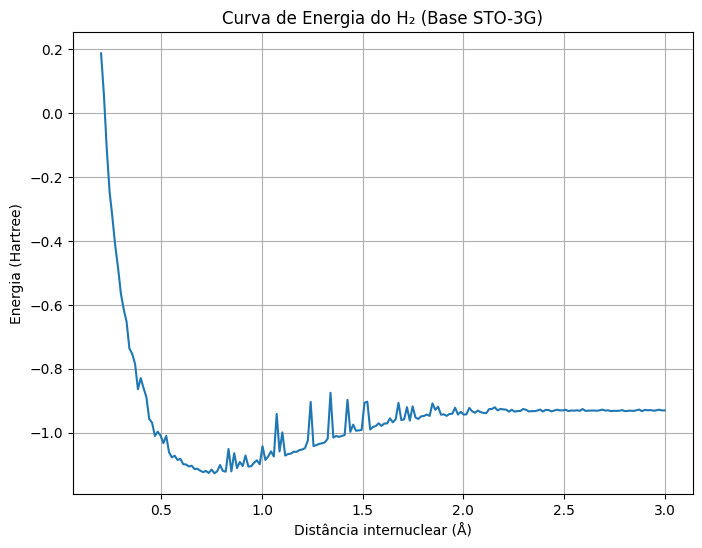

Menor energia: -1.126781 Hartree
Distância correspondente: 0.762814 Å


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit.opflow import PauliSumOp
from qiskit.algorithms.optimizers import L_BFGS_B
from pyscf import gto

distancias = np.linspace(0.20,3,200)
energias = []

for d in distancias:
    d_str = f"{d:.2f}".replace(".", "_")

    mol = gto.M(atom=f"H 0 0 0; H 0 0 {d}",
                basis="sto-3g",
                unit="Angstrom"
                )
    energia_nuclear = mol.energy_nuc()


    h_ks = np.loadtxt(f"h_mo_{d_str}.txt")

    # Tensor g_ks fornecido
    g_ks = np.loadtxt(f"g_mo_{d_str}.txt")
    g_ks = g_ks.reshape(2, 2, 2, 2)

    n_orb = h_ks.shape[0]
    #Criação dos orbitais de spin
    n_spin_orb = 2 * n_orb

    # --- Termo de 1 elétron --- com a adição dos orbitais de spin
    h1_dict = {}
    for p in range(n_spin_orb):
        for q in range(n_spin_orb):
            if (p % 2) == (q % 2):
                i, j = p // 2, q // 2
                val = h_ks[i, j]
                if abs(val) > 1e-10:
                    h1_dict[f"+_{p} -_{q}"] = val

    h1 = FermionicOp(h1_dict, num_spin_orbitals=n_spin_orb)

    # --- Termo de 2 elétrons --- com a adição dos orbitais de spin
    h2_dict = {}
    for p in range(n_spin_orb):
        for q in range(n_spin_orb):
            for r in range(n_spin_orb):
                for s in range(n_spin_orb):
                    if (p % 2 == r % 2) and (q % 2 == s % 2):
                        i, j, k, l = p // 2, q // 2, r // 2, s // 2
                        val = g_ks[i, j, k, l]
                        if abs(val) > 1e-10:
                            h2_dict[f"+_{p} +_{q} -_{s} -_{r}"] = 0.5 * val

    h2 = FermionicOp(h2_dict, num_spin_orbitals=n_spin_orb)

    fermionico_op = h1 + h2

    mapper = JordanWignerMapper()
    qubit_op = mapper.map(fermionico_op)

    #VQE
    ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, reps = 6, entanglement = 'full')

    vqe = VQE(
        Estimator(),
        ansatz=ansatz,
        optimizer=COBYLA(maxiter = 400),
        initial_point=[0.0] * ansatz.num_parameters
    )

    vqe_resultado = vqe.compute_minimum_eigenvalue(qubit_op)
    energia_eletronica = vqe_resultado.eigenvalue.real
    total_energy = energia_eletronica + energia_nuclear
    energias.append(total_energy)

plt.figure(figsize=(8, 6))
plt.plot(distancias, energias)
plt.title("Curva de Energia do H₂ (Base STO-3G)")
plt.xlabel("Distância internuclear (Å)")
plt.ylabel("Energia (Hartree)")
plt.grid(True)
plt.show()

# Encontrar o índice da menor energia
idx_min = np.argmin(energias)

# A menor energia e a distância correspondente
energia_minima = energias[idx_min]
distancia_minima = distancias[idx_min]

print(f"Menor energia: {energia_minima:.6f} Hartree")
print(f"Distância correspondente: {distancia_minima:.6f} Å")

#print("\nEnergia eletrônica (VQE):", energia_eletronica)
#print("Energia nuclear:", energia_nuclear)
#print("Energia total (VQE):", total_energy)

In [ ]:
import numpy as np
from pyscf import gto, dft

mol = gto.M(atom=f"H 0 0 -0.74; H 0 0 0.74; H 0.74 0 0; H -0.74 0 0",
                basis="sto-3g",
                unit="Angstrom",
                verbose = 0
                )

energia_nuclear = mol.energy_nuc()


mf = dft.RKS(mol)
mf.xc = 'b3lyp'
mf.kernel()

hcore = mf.get_hcore()
n = hcore.shape[0]
eri_ao = mol.intor('int2e')
eri_ao_flat = eri_ao.reshape(n**2, n**2)  # 2x2 = 4
C = mf.mo_coeff

np.savetxt(f"integral_1e_H4.txt", hcore, fmt="%.10f")
np.save(f"integral_2e_H4.npy",eri_ao)
np.savetxt(f"coef_KS_H4.txt", C, fmt="%.10f")


In [ ]:
import numpy as np

h_ao = np.loadtxt("integral_1e_H4.txt")  # 2x2 #Base atomica
eri_ao_flat = np.load("integral_2e_H4.npy") #Base atômica
C = np.loadtxt(f"coef_KS_H4.txt")

#eri_ao = eri_ao_flat.reshape(4, 4, 4, 4)
h_mo = C.T @ h_ao @ C

g_mo = np.zeros((4, 4, 4, 4))

for i in range(4):
    for j in range(4):
        for k in range(4):
            for l in range(4):
                for p in range(4):
                    for q in range(4):
                        for r in range(4):
                            for s in range(4):
                                g_mo[i, j, k, l] += (
                                C[p, i] * C[r, k] *
                                eri_ao[p, r, q, s] *
                                C[q, j] * C[s, l]
                                )


np.savetxt("h_mo_H4.txt", h_mo, fmt="%.10f")
np.save("g_mo_H4.npy", g_mo)


In [ ]:
import numpy as np
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit.opflow import PauliSumOp
from qiskit.algorithms.optimizers import L_BFGS_B
from pyscf import gto


mol = gto.M(atom=f"H 0 0 -0.74; H 0 0 0.74; H 0.74 0 0; H -0.74 0 0",
                basis="sto-3g",
                unit="Angstrom"
                )

energia_nuclear = mol.energy_nuc()

h_ks = np.loadtxt(f"h_mo_H4.txt")
g_ks = np.load(f"g_mo_H4.npy")

n_orb = h_ks.shape[0]

n_spin_orb = 2 * n_orb

    # --- Termo de 1 elétron --- com a adição dos orbitais de spin
h1_dict = {}
for p in range(n_spin_orb):
      for q in range(n_spin_orb):
        if (p % 2) == (q % 2):
            i, j = p // 2, q // 2
            val = h_ks[i, j]
            if abs(val) > 1e-10:
                h1_dict[f"+_{p} -_{q}"] = val

h1 = FermionicOp(h1_dict, num_spin_orbitals=n_spin_orb)

# --- Termo de 2 elétrons --- com a adição dos orbitais de spin
h2_dict = {}
for p in range(n_spin_orb):
    for q in range(n_spin_orb):
        for r in range(n_spin_orb):
            for s in range(n_spin_orb):
                if (p % 2 == r % 2) and (q % 2 == s % 2):
                    i, j, k, l = p // 2, q // 2, r // 2, s // 2
                    val = g_ks[i, j, k, l]
                    if abs(val) > 1e-10:
                        h2_dict[f"+_{p} +_{q} -_{s} -_{r}"] =  0.5 * val

h2 = FermionicOp(h2_dict, num_spin_orbitals=n_spin_orb)

fermionico_op = h1 + h2

mapper = JordanWignerMapper()
qubit_op = mapper.map(fermionico_op)

#VQE
ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, reps = 1, entanglement = 'full')

vqe = VQE(
    Estimator(),
    ansatz=ansatz,
    optimizer=COBYLA(maxiter = 400),
    initial_point=[0.0] * ansatz.num_parameters
)

vqe_resultado = vqe.compute_minimum_eigenvalue(qubit_op)
energia_eletronica = vqe_resultado.eigenvalue.real
total_energy = energia_eletronica + energia_nuclear


print("\nEnergia eletrônica (VQE):", energia_eletronica)
print("Energia nuclear:", energia_nuclear)
print("Energia total (VQE):", total_energy)


8

Energia eletrônica (VQE): -4.611915873297651
Energia nuclear: 2.7377248487617085
Energia total (VQE): -1.8741910245359423


In [ ]:
from pyscf import gto, dft
import numpy as np


mol = gto.M(
    atom="""
        H 0.00  0.00 -0.74
        H 0.00  0.00  0.74
        H 0.74  0.00  0.00
        H -0.74 0.00  0.00
    """,
    basis="sto-3g",
    unit="Angstrom",
    verbose=0
)

mf = dft.RKS(mol)
mf.xc = 'b3lyp'
E_DFT = mf.kernel()

print(f"Energia total do H4 (DFT-B3LYP, sto-3g): {E_DFT:.8f} Ha")


/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:512: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Energia total do H4 (DFT-B3LYP, sto-3g): -1.92416038 Ha
